# Analytic-DPM: an Analytic Estimate of the Optimal Reverse Variance in Diffusion Probabilistic Models

# https://arxiv.org/pdf/2201.06503

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Training ε-model (few epochs for demo)...
[eps] epoch 1/3  loss=0.0742
[eps] epoch 2/3  loss=0.0437
[eps] epoch 3/3  loss=0.0408
Estimating Γ_t...
Sampling with Analytic-DPM (K=50)...


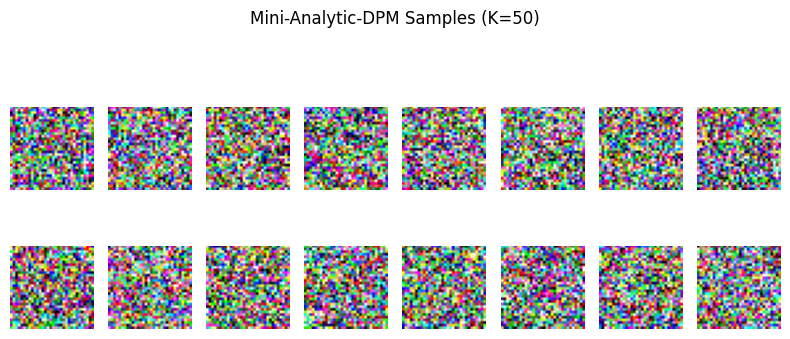

In [1]:
# ----------------------------------------------------------
# Mini-Analytic-DPM: A Didactic Replication of
# "Analytic-DPM: An Analytic Estimate of the Optimal Reverse Variance
# in Diffusion Probabilistic Models" (ICLR 2022)
# ----------------------------------------------------------
# Pipeline:
#  1) Train tiny DDPM ε-model on CIFAR-10
#  2) Estimate Γ_t = E[ ||s_t(x_t)||^2 ] / d  via Monte Carlo (score from ε-model)
#  3) Compute analytic σ_hat^2(t) with clipping bounds
#  4) Sample with short even-trajectory using σ_hat^2
# ----------------------------------------------------------

import math, torch, torch.nn as nn, torch.optim as optim
import torchvision, torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# 1) Data (CIFAR-10; [-1,1])
# -----------------------------
tfm = T.Compose([T.ToTensor(), T.Normalize((0.5,)*3, (0.5,)*3)])
train = torchvision.datasets.CIFAR10("./data", train=True,  download=True, transform=tfm)
test  = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=tfm)
train_loader = DataLoader(train, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
classes = train.classes

# -----------------------------
# Helpers: schedule
# -----------------------------
def make_beta_schedule(T=1000, beta_start=1e-4, beta_end=0.02):
    betas = torch.linspace(beta_start, beta_end, T, device=device)
    alphas = 1.0 - betas
    abar = torch.cumprod(alphas, dim=0)          # \bar{α}_t
    abar_prev = torch.cat([torch.tensor([1.0], device=device), abar[:-1]])
    # DDPM special: \tilde{β}_t
    beta_tilde = (1 - abar_prev) / (1 - abar) * betas
    return betas, alphas, abar, abar_prev, beta_tilde

T_total = 1000
betas, alphas, abar, abar_prev, beta_tilde = make_beta_schedule(T_total)

# -----------------------------
# Tiny ε-UNet (pixel space)
# -----------------------------
def time_embed(t, dim=128):
    """Sinusoidal embedding for integer t (B,) -> (B,dim)."""
    half = dim // 2
    freqs = torch.exp(-math.log(10000)*torch.arange(0, half, device=device)/half)
    args = t[:,None].float()*freqs[None]
    return torch.cat([torch.sin(args), torch.cos(args)], dim=1)

class ResBlock(nn.Module):
    def __init__(self, ch, tdim):
        super().__init__()
        self.n1 = nn.GroupNorm(8, ch); self.act = nn.SiLU(); self.c1 = nn.Conv2d(ch, ch, 3, 1, 1)
        self.fc = nn.Linear(tdim, ch)
        self.n2 = nn.GroupNorm(8, ch); self.c2 = nn.Conv2d(ch, ch, 3, 1, 1)
    def forward(self, x, temb):
        h = self.c1(self.act(self.n1(x)))
        h = h + self.fc(temb)[:, :, None, None]
        h = self.c2(self.act(self.n2(h)))
        return x + h

class TinyEpsUNet(nn.Module):
    def __init__(self, base=64, tdim=128):
        super().__init__()
        self.tproj = nn.Sequential(nn.Linear(tdim, tdim), nn.SiLU(), nn.Linear(tdim, tdim))
        self.inp = nn.Conv2d(3, base, 3, 1, 1)
        self.b1  = ResBlock(base, tdim)
        self.down= nn.Conv2d(base, base, 4, 2, 1)   # 32->16
        self.b2  = ResBlock(base, tdim)
        self.up  = nn.ConvTranspose2d(base, base, 4, 2, 1) # 16->32
        self.b3  = ResBlock(base, tdim)
        self.out = nn.Conv2d(base, 3, 3, 1, 1)
    def forward(self, x, t):
        temb = self.tproj(time_embed(t))
        h = self.inp(x)
        h = self.b1(h, temb)
        d = self.down(h)
        d = self.b2(d, temb)
        u = self.up(d)
        h = self.b3(h + u, temb)
        return self.out(h)

eps_model = TinyEpsUNet().to(device)
opt = optim.AdamW(eps_model.parameters(), lr=1e-3)

# -----------------------------
# Forward/noise utilities
# -----------------------------
@torch.no_grad()
def q_sample(x0, t, noise=None):
    """x_t = sqrt(abar_t) x0 + sqrt(1-abar_t) eps"""
    if noise is None: noise = torch.randn_like(x0)
    a = torch.sqrt(abar[t])[:, None, None, None]
    b = torch.sqrt(1 - abar[t])[:, None, None, None]
    return a*x0 + b*noise

def ddpm_loss_step(x0):
    B = x0.size(0)
    t = torch.randint(0, T_total, (B,), device=device)
    eps = torch.randn_like(x0)
    x_t = q_sample(x0, t, eps)
    eps_pred = eps_model(x_t, t)
    return nn.functional.mse_loss(eps_pred, eps)

print("Training ε-model (few epochs for demo)...")
eps_model.train()
for epoch in range(3):
    run = 0.0
    for xb, _ in train_loader:
        xb = xb.to(device, non_blocking=True)
        loss = ddpm_loss_step(xb)
        opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
        run += loss.item()
    print(f"[eps] epoch {epoch+1}/3  loss={run/len(train_loader):.4f}")

# ---------------------------------------------------
# 2) Monte Carlo Γ_t using score s_t = -(1/√β_t) ε̂_t
#     Γ_t ≈ E[ ||s_t(x_t)||^2 ] / d
# ---------------------------------------------------
@torch.no_grad()
def estimate_Gamma(num_batches=50):
    d = 3*32*32
    Γ = torch.zeros(T_total, device=device)
    counts = torch.zeros(T_total, device=device)
    eps_model.eval()
    it = iter(train_loader)
    for _ in range(num_batches):
        try:
            x0,_ = next(it)
        except StopIteration:
            it = iter(train_loader); x0,_ = next(it)
        x0 = x0.to(device)
        t = torch.randint(1, T_total, (x0.size(0),), device=device)  # exclude t=0
        x_t = q_sample(x0, t)
        eps_hat = eps_model(x_t, t)
        s = -eps_hat / torch.sqrt(betas[t])[:, None, None, None]     # footnote equivalence
        sq = s.reshape(s.size(0), -1).pow(2).sum(dim=1) / d
        for i, ti in enumerate(t):
            Γ[ti] += sq[i]
            counts[ti] += 1
    Γ = torch.where(counts>0, Γ / counts.clamp_min(1), torch.zeros_like(Γ))
    Γ[0] = Γ[1] # safe fill
    return Γ

print("Estimating Γ_t...")
Gamma = estimate_Gamma(num_batches=50)

# ---------------------------------------------------
# 3) Analytic σ_hat^2(t) + clipping bounds (DDPM case)
#     σ̂_t^2 = λ_t^2 + ( sqrt(β_t/ᾱ_t) - sqrt(β_{t-1}-λ_t^2) )^2 * (1 - β_t Γ_t)
#     Bounds: lower λ_t^2; upper λ_t^2 + ( sqrt(β_t/ᾱ_t) - sqrt(β_{t-1}-λ_t^2) )^2
# ---------------------------------------------------
@torch.no_grad()
def analytic_sigma_hat_sq(Gamma):
    lam2 = beta_tilde
    beta = betas
    beta_prev = torch.cat([beta[:1], 1 - abar_prev[1:]])  # β_{t-1} = 1 - \bar{α}_{t-1}
    c1 = torch.sqrt(beta / abar.clamp_min(1e-12))
    c2 = torch.sqrt((beta_prev - lam2).clamp_min(1e-12))
    core = (c1 - c2).pow(2)
    sigma2 = lam2 + core * (1 - beta * Gamma.clamp_min(0.0))
    # clip to bounds (Eq. 11)
    lower = lam2
    upper = lam2 + core
    return sigma2.clamp(min=lower, max=upper)

sigma2_hat = analytic_sigma_hat_sq(Gamma)

# ---------------------------------------------------
# 4) Sampling with short even-trajectory (K steps)
#     Use μθ with ε̂ and variance = σ̂^2
# ---------------------------------------------------
@torch.no_grad()
def sample_analytic_dpm(n=16, K=50):
    eps_model.eval()
    # even trajectory indices (1..T)
    idx = torch.linspace(1, T_total, steps=K, device=device).round().long() - 1
    x = torch.randn(n, 3, 32, 32, device=device)
    for i in reversed(range(K)):
        t = idx[i]
        tb = torch.full((n,), t, device=device, dtype=torch.long)
        eps_hat = eps_model(x, tb)
        # μθ(x_t,t) = 1/√α_t (x_t - (β_t/√(1-ᾱ_t)) ε̂)
        mu = (1/torch.sqrt(alphas[t]))*(x - (betas[t]/torch.sqrt(1 - abar[t]))*eps_hat)
        if i > 0:
            noise = torch.randn_like(x)
            std = torch.sqrt(sigma2_hat[t]).clamp_min(1e-12)
            x = mu + std * noise
        else:
            x = mu
    return x.clamp(-1,1)

print("Sampling with Analytic-DPM (K=50)...")
samples = sample_analytic_dpm(n=16, K=50).cpu()

# -----------------------------
# Visualize samples
# -----------------------------
def show_grid(xb, title):
    imgs = (xb*0.5 + 0.5).numpy()
    plt.figure(figsize=(8,4)); plt.suptitle(title)
    for i in range(min(16, imgs.shape[0])):
        plt.subplot(2,8,i+1); plt.imshow(np.transpose(imgs[i], (1,2,0))); plt.axis('off')
    plt.tight_layout(); plt.show()

show_grid(samples, "Mini-Analytic-DPM Samples (K=50)")


In [5]:
# Make sure torchinfo is installed
!pip install -q torchinfo
from torchinfo import summary

# Define timesteps if missing
T_steps = 200  # diffusion steps (adjust as needed)

# Pick your score model variable
try:
    score_net = eps_model   # UNet from your Analytic-DPM code
except NameError:
    raise ValueError("Please define your score model (eps_model).")

# Recall summary
feat = summarize_analytic_dpm(
    score_model=score_net,
    input_shape=(1, 3, 32, 32),
    T=T_steps,
    beta_schedule="linear",
    sampler="Analytic-DPM",
    loss_type="eps",
    analytic_variance=True,
    guidance="none",
    guidance_scale=None,
    inference_steps=50,
    ema_decay=None
)

print("\nTotal parameters (M):", round(feat.parameters_total / 1e6, 3))



=== Analytic-DPM Feature Sheet ===
            model_name: TinyEpsUNet
      parameters_total: 414851
  parameters_trainable: 414851
           input_shape: (1, 3, 32, 32)
        image_channels: 3
      image_resolution: 32x32
           timesteps_T: 200
         beta_schedule: linear
               sampler: Analytic-DPM
             loss_type: eps
     analytic_variance: True
              guidance: none
        guidance_scale: None
       inference_steps: 50
             ema_decay: None
                 dtype: float32
                device: cuda:0

(torchinfo not installed; install with `pip install torchinfo` for layer-wise summary)

Total parameters (M): 0.415


In [8]:
!pip install -q  torchinfo

In [10]:
score_net

TinyEpsUNet(
  (tproj): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (inp): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (b1): ResBlock(
    (n1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (act): SiLU()
    (c1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc): Linear(in_features=128, out_features=64, bias=True)
    (n2): GroupNorm(8, 64, eps=1e-05, affine=True)
    (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (down): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (b2): ResBlock(
    (n1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (act): SiLU()
    (c1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc): Linear(in_features=128, out_features=64, bias=True)
    (n2): GroupNorm(8, 64, eps=1e-05, affine=True)
    (c2): Conv2d(64, 64, kernel_size=(

In [13]:
import json
from dataclasses import asdict

with open("analytic_dpm_feature_sheet.json","w") as f:
    json.dump(asdict(feat), f, indent=2)

md = "## Analytic-DPM Feature Sheet\n\n| Field | Value |\n|---|---|\n" + \
     "\n".join(f"| {k} | {v} |" for k,v in asdict(feat).items())
open("analytic_dpm_feature_sheet.md","w").write(md)

print("Saved: analytic_dpm_feature_sheet.md and .json")


Saved: analytic_dpm_feature_sheet.md and .json
